# Create CSV files with FHR from the binary files provided in the FHRMA toolbox

## Use of the FHRMA toolbox and code

FHR Morphological Analysis Toolbox  Copyright (C) 2018 Samuel Boudet, Faculté de Médecine et Maïeutique,

samuel.boudet@gmail.com

FHR Morphological Analysis Toolbox  is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

FHR Morphological Analysis Toolbox  is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

GNU General Public License - <http://www.gnu.org/licenses/>.

## About the CTG files
The FHRMA toolbox provides 66 training files and 90 test files with raw CTG data. They are stored as binary .fhr files. The signals were sampled at 4 Hz and stored in the following format. For each sample:
* A uint32 serves as the UNIX timestamp for the beginning of the recording
* A uint16 corresponds to the FHR from the first sensor (multiplied by 4)
* A uint16 for the FHR signal from the second sensor (multiplied by 4) (unused here)
* A uint8 for the TOCO signal (multiplied by 2)
* A uint8 reserved to store signal quality (unused here).

The FHR signal is set to 0 when it is missing.

## Background information on binary files
Binary files consist of sequential bytes, which are each 8 bits long. Bits are 0s and 1s.

Binary files typically have a header indicating the file type.

A byte can represent a number from 0 to 255, or -127 to +127 if you use one bit to indicate the minus sign. Groups of bytes can be used to represent larger numbers, for example:
| Number of bytes (or bits) | Name | Range (will - this to + this) |
| --- | --- | --- |
| 1 (8 bits) | Byte | 128 |
| 2 (16 bits) | Short | 32,768 |
| 4 (32 bits) | Int | 2,147,483,648 |
| 8 (64 bits) | Int64 | 9,223,372,036,854,775,808 |

## Implementation in MATLAB

The .fhr files can be opened with the `fhropen.m` function in MATLAB - below is an excerpt that will open a file and save to csv (their version didn't include that, was just when I was testing in Octave) -

```
clear;

% Set filename
filename='test02';

% Open file
f=fopen([filename, '.fhr'], 'r');

% Load timestamp for beginning of recording
timestamp=fread(f,1,'uint32');

% Load FHR data - first corresponds to first sensor, and
% second corresponds to second sensor (which they don't use)
% This reads 3 x 10,000,000 array
data=fread(f,[3,10000000],'uint16');
FHR1=data(1,:)/4;
FHR2=data(2,:)/4;

fseek(f,4,'bof');

% TOCO signal
data=fread(f,[6,10000000],'uint8');
TOCO=data(5,:)/2;

MHR=zeros(size(FHR1));
infos=[];
fclose(f);

% Save FHR1 to a file for use in python
csvwrite([filename, '.csv'], transpose(FHR1));
```

I believe they then applied pre-processing using their function `preprocess.m`, which is copied below (d if first sample of non-missing signal, and f is last sample of non-missing signal) -

```
function [FHRi,FHR,TOCO,d,f]=preprocess(FHR1,FHR2,TOCO,unreliableSignal)

FHR=max([FHR1;FHR2]);
if nargin>=4
    for j=1:size(unreliableSignal,1)
        FHR(round(unreliableSignal(j,1)*240+1):round(unreliableSignal(j,2)*240))=0;
    end
end
FHR=removesmallpart(FHR);
d=find(FHR>0,1);


[FHRi,d,f]=interpolFHR(FHR);
%FHRi=FHRi(d:f);TOCOi=TOCO(d:f);FHR=FHR(d:f);
FHR(FHR==0)=NaN;
```

That function uses `removesmallpart()` which is copied below also.

```
function FHR=removesmallpart(FHR)
    FHR(FHR>220|FHR<50)=0;
    n=find(FHR(1:end-1)==0 & FHR(2:end)>0)+1;
    for i=1:length(n)
        f=find(FHR(n(i):end)==0,1,'first');
        if f<5*4
        	FHR(n(i):n(i)+f)=0;
        end
    end
    
    
    n=find(FHR(1:end-1)==0 & FHR(2:end)>0)+1;
    for i=1:length(n)
        f=find(FHR(n(i):end)==0,1,'first');
        if f<30*4
            
            lastvalid=find(FHR(1:n(i)-1)>0,1,'last');
            nextvalid=find(FHR(n(i)+f:end)>0,1,'first')+n(i)+f-1;
            
            try
                if(  (FHR(n(i))-FHR(lastvalid)<-25 && FHR(n(i)+f-2)-FHR(nextvalid)<-25 ))
                    FHR(n(i):n(i)+f)=0;
                end
                if(  (FHR(n(i))-FHR(lastvalid)>25 && FHR(n(i)+f-2)-FHR(nextvalid)>25 ))
                    FHR(n(i):n(i)+f)=0;
                end
            catch
            end
        end
    end

end
```

## Implementation in Python

### Set up

Load required packages.

In [1]:
from dataclasses import dataclass
import glob
from itertools import groupby
import matplotlib.pyplot as plt
import numpy as np
import os
from operator import itemgetter
import pandas as pd

Define file paths.

In [2]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    fhrma = './fhrma/train_test_data/'
    train_fhr = 'traindata_fhr/'
    test_fhr = 'testdata_fhr/'
    train_csv = 'traindata_csv/'
    test_csv = 'testdata_csv/'


paths = Paths()

### Define functions for import and pre-processing

Define function for extracting FHR and saving to csv.

In [3]:
def import_fhr(file_path):
    '''
    Imports .fhr files, extracts the data corresponding to FHR1 and FHR2

    Parameters:
    -----------
    file_path : string
        Location of the .fhr file

    Outputs:
    --------
    fhr1 : array
        FHR signal from the first sensor
    fhr2: array
        FHR signal from the second sensor
    name: string
        Name of the record for these FHR signals
    '''
    # Read file as uint16
    content = np.fromfile(file_path, dtype=np.uint16)

    # Ignore first two bytes, then reshape so you have a 3 x n array
    data = content[2:10000000-1].reshape(-1, 3).T

    # Take first array which corresponds to first sensor
    fhr1 = data[0]/4
    # Take second array which corresponds to second sensor
    fhr2 = data[1]/4

    # Get file name (remove path, change to csv)
    name = file_path.rsplit('/', 1)[1].replace('.fhr', '.csv')

    return(fhr1, fhr2, name)

Define functions used for pre-processing of the FHR signals.

In [4]:
def remove_small_part(fhr):
    '''
    Remove small sections of the signal that are non-physiological or extreme
    values (e.g. FHR too high, too low, or too great a change in a small period
    of time), and remove really short sections of signal surrounded by missing
    signal.

    Parameters
    ----------
    fhr : array
        Fetal heart rate

    Outputs:
    --------
    fhr : array
        Cleaned version of FHR
    '''
    # Remove extreme - set FHR to 0 if it is greater than 220bpm or less than 50bpm
    fhr[np.logical_or(fhr>220, fhr<50)] = 0

    # Find section of FHR that is preceded and followed by zero values - if that
    # section of non-zero values is too short (less than or equal to 5 seconds),
    # set all values in that section to zero

    # Get indices where FHR transitions from zero to non-zero value
    # (e.g. if n has index 396, then 395 was 0 and 396 was not zero)
    n = np.where((fhr[:-1] == 0) & (fhr[1:] > 0))[0] + 1

    # Loop through each of those transition points
    for i in range(len(n)):

        # Get array with all indexes of zero after this point
        zeros = np.where(fhr[n[i]:] == 0)[0]
        # If there were any zeros, get index of the closest (the first)
        if len(zeros) > 0:

            # f is the length of the non-0 section before the next 0
            f = zeros[0]

            # If f is less than 5 seconds (5*4), set that whole section to zero
            if f < 5*4:
                fhr[n[i]:n[i]+f] = 0

            # If f is less than 30 seconds (30*4)
            if f < 30*4:
                # Get array of point before start of zero section before n, and
                # after zero section after f, that are non-zero
                valid_before = np.where(fhr[:n[i]] > 0)[0]
                valid_after = np.where(fhr[n[i]+f:] > 0)[0]
                # As long as there were non-zeros both before and after...
                if (len(valid_before) > 0) and (len(valid_after) > 0):
                    # Get index of last and first non-zero
                    last_valid = valid_before[-1]
                    first_valid = valid_after[0] + n[i] + f
                    # Find difference in FHR between lastvalid and n(i)
                    lastvalid_diff = fhr[n[i]] - fhr[last_valid]
                    # Find difference in FHR between last non-zero in f section, and nextvalid
                    nextvalid_diff = fhr[n[i]+f-2] - fhr[first_valid]
                    # If both of those differences are more than an absolute value of 25bpm,
                    # then set that f section of non-zero all to 0
                    if (abs(lastvalid_diff) > 25) and (abs(nextvalid_diff) > 25):
                        fhr[n[i]:n[i]+f] = 0

    return (fhr)

In [5]:
def interpol_fhr(fhr):
    '''
    Interpolation of missing signal, to match interpolfhr() in FHRMA

    Parameters
    ----------
    fhr : array
        Fetal heart rate

    Outputs:
    --------
    fhr : array
        Cleaned version of FHR
    '''
    # Get the first index where FHR is non-zero and non-NaN
    n = np.argmax(np.logical_and(fhr>0, np.isfinite(fhr)))

    # Set any values preceding that index to the value of that index
    fhr[:n] = fhr[n]

    # While you have a value of n, and whilst it's not reached the end of the FHR
    while n is not None and n!=-1:

        # Get index of first occurence after n that is zero or NaN
        n = np.argmax(np.logical_or(fhr==0, ~np.isfinite(fhr)))

        # Make boolean array of non-zero or non-NaN after n
        nf_mask = np.logical_and(fhr[n:]>0, np.isfinite(fhr[n:]))

        # If you have found a subsequent value that is non-zero or non-NaN...
        if nf_mask.any() and n!=0:

            # Get the index of the first value that is non-zero and non-NaN
            nf = np.argmax(nf_mask)+n

            # Linear interpolation between nf and the non-zero point before n
            # Round to 3dp to match with MATLAB
            fhr[(n-1):(nf+1)] = np.linspace(fhr[n-1], fhr[nf], nf-n+2)

            # Set n to nf
            n = nf

        # If there were no subsequent values, exit the while loop
        else:
            n=-1

    # Get last index where FHR is non-zero and non-NaN
    n = pd.Series(np.logical_and(fhr>0, np.isfinite(fhr)))[::-1].idxmax()

    # Set any values following that index to the value of that index
    fhr[n:] = fhr[n]

    return (fhr)

In [6]:
def preprocess(fhr1, fhr2):
    '''
    Pre-process the FHR1 and FHR2 signals - merging the signals from each
    sensor, removing empty signal at the beginning and end, removing small parts
    of the signal that are not trustable, and linear interpolation of missing
    parts of the signal.

    Parameters:
    -----------
    fhr1 : array
        FHR signal from the first sensor
    fhr2: array
        FHR signal from the second sensor

    Outputs:
    --------
    new_sig : array
        Cleaned FHR signal
    '''
    # Find the max value element-wise of the two arrays
    # This should hopefully fill the occurences where FHR=0 (i.e. no signal)
    fhr = np.maximum(fhr1, fhr2)

    # Clean using removesmallpart() - this will remove small sections of the
    # signal that are non-physiological or extreme values (e.g. FHR too high,
    # too low, or too great a change in a small period of time), and remove
    # really short sections of signal surrounded by missing signal.
    fhr = remove_small_part(fhr)

    # Perform linear interpolation
    fhr = interpol_fhr(fhr)

    # If any zero remain, set to NaN
    fhr[fhr==0] = np.nan

    # Round all values to 13dp as in MATLAB
    #fhr = np.around(fhr, 13)

    # Return the cleaned signal
    return (fhr)

Define function for import, pre-processing and saving to csv for all files in a given directory

In [7]:
def convert_fhr_to_csv(fhr_path, csv_path):
    '''
    Imports all .fhr files in a given directory, extracts the data corresponding
    to FHR1 and FHR2, pre-process and save to csv.

    Parameters:
    -----------
    fhr_path : string
        Location of .fhr files
    csv_path : string
        Location to save the .csv files
    '''
    # Get list of all the .fhr file names in the directory
    files = glob.glob(os.path.join(fhr_path, '*.fhr'))

    # Loop through those files...
    for file_path in files:

        print(f'Started: {file_path}')

        # Import the signals and record name
        fhr1, fhr2, name = import_fhr(file_path)

        # Pre-process the signals
        fhr = preprocess(fhr1, fhr2)

        # Save to csv
        np.savetxt(os.path.join(csv_path, name), fhr, delimiter=',')

### Run functions on an example, to help demonstrate impact of the cleaning process

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[146.25 147.   147.   146.5  146.5  146.   146.25 146.25 145.   145.  ]
train40.csv


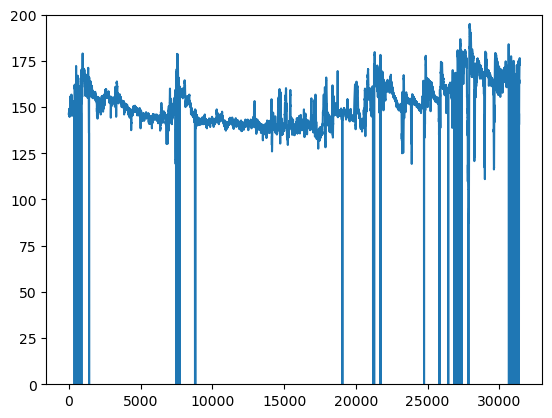

In [8]:
# Import an example file
file_path = os.path.join(paths.fhrma, paths.train_fhr, 'train40.fhr')
fhr1, fhr2, name = import_fhr(file_path)

# Preview data
print(fhr1[:10])
print(fhr2[:10])
print(name)

# Plot one of the data
plt.plot(fhr2)
plt.ylim([0, 200])
plt.show()

[146.25 147.   147.   146.5  146.5  146.   146.25 146.25 145.   145.  ]


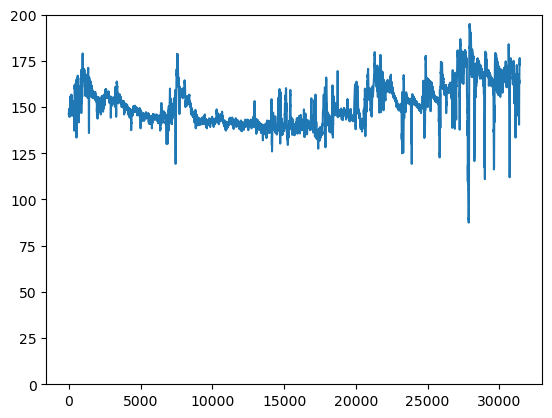

In [9]:
# Pre-process
fhr = preprocess(fhr1, fhr2)

# Preview
print(fhr[:10])

# Plot
plt.plot(fhr)
plt.ylim([0, 200])
plt.show()

### Apply functions to the training and test datasets

In [10]:
convert_fhr_to_csv(
    fhr_path = os.path.join(paths.fhrma, paths.train_fhr),
    csv_path = os.path.join(paths.fhrma, paths.train_csv)
)

Started: ./fhrma/train_test_data/traindata_fhr/train64.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train55.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train13.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train17.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train49.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train40.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train46.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train43.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train29.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train08.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train07.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train28.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train18.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train47.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train61.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train21.fhr
Started: ./fhrma/train_test_data/traindata_fhr/train57.f

In [11]:
convert_fhr_to_csv(
    fhr_path = os.path.join(paths.fhrma, paths.test_fhr),
    csv_path = os.path.join(paths.fhrma, paths.test_csv)
)

Started: ./fhrma/train_test_data/testdata_fhr/test75.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test40.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test23.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test06.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test54.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test51.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test65.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test45.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test87.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test74.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test88.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test41.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test55.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test05.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test15.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test50.fhr
Started: ./fhrma/train_test_data/testdata_fhr/test11.fhr
Started: ./fhrma/train_test_dat

## Compare MATLAB and Python implementation

To validate implementation in Python, compare against the signals obtained from Octave (MATLAB).

In [12]:
def import_csv(directory, output_dict):
    '''
    Import csv files from provided directory and save to output_dict
    Inputs:
    directory - string, location of csv files
    output_dict - dictionary, to save files to
    '''
    # Get list of .csv files in directory
    files = glob.glob(os.path.join(directory, '*.csv'))

    # Loop through files in the directory
    for file in files:
        # Get raw name of record (without path or file type)
        name = file.replace(directory, '').replace('.csv', '')
        # Import and save to dictionary, rounding as import
        output_dict[name] = pd.read_csv(file, header=None)[0].values
        #output_dict[name] = np.around(
        #    pd.read_csv(file, header=None)[0].values, 13)

    return output_dict

In [13]:
# Import and csv files produced in python
fhr_python = import_csv(
    directory='./fhrma/train_test_data/traindata_csv/',
    output_dict=dict())
fhr_python = import_csv(
    directory='./fhrma/train_test_data/testdata_csv/',
    output_dict=fhr_python)
fhr_python_df = pd.DataFrame([[key,value] for key,value in fhr_python.items()],
                             columns=['record', 'python'])

# Import and csv files produced in Octave
fhr_fhrma = import_csv(
    directory='./fhrma/train_test_data/traindata_octave_csv/',
    output_dict=dict())
fhr_fhrma = import_csv(
    directory='./fhrma/train_test_data/testdata_octave_csv/',
    output_dict=fhr_fhrma)
fhr_fhrma_df = pd.DataFrame([[key,value] for key,value in fhr_fhrma.items()],
                            columns=['record', 'fhrma'])

#### Rounding differences

As you'll see below, lots of the differences are rounding. MATLAB results are to 13 decimal places whilst Python are to 14. In MATLAB, in cases where a value is halfway between two points (i.e. ends with a decimal 5), it willL
* Round down if 35, 455
* Round up if 555, 65, 75 

In [14]:
# Merge into a single dataframe
compare_fhr = pd.merge(fhr_python_df, fhr_fhrma_df)

# Loop through each record, comparing the python and FHRMA results
for index, row in compare_fhr.iterrows():

    # Extract the two arrays
    res_python = row['python']
    res_fhrma = row['fhrma']

    # Save number of matches, total possible matches, and every element matches
    compare_fhr.loc[compare_fhr.index[index], 'n_match'] = (res_python==res_fhrma).sum()
    compare_fhr.loc[compare_fhr.index[index], 'total_possible'] = len(res_python)
    compare_fhr.loc[compare_fhr.index[index], 'all_match'] = (res_python==res_fhrma).all()

    # Find element wise differences
    diff = res_python - res_fhrma
    compare_fhr.loc[compare_fhr.index[index], 'sum_abs_diff'] = abs(diff).sum()

# Add column with rounded sum_abs_diff
compare_fhr['sum_abs_diff_round5dp'] = round(compare_fhr['sum_abs_diff'], 5)

# Add column showing number of non-matching elements
compare_fhr['n_different'] = compare_fhr['total_possible'] - compare_fhr['n_match']

# Preview dataframe
compare_fhr.head(20)

,record,python,fhrma,n_match,total_possible,all_match,sum_abs_diff,sum_abs_diff_round5dp,n_different
0,train28,"[136.5, 136.5, 136.5, 135.5, 135.5, 135.5, 136...","[136.5, 136.5, 136.5, 135.5, 135.5, 135.5, 136...",17595.0,17595.0,True,0.000000e+00,0.000,0.0
1,train04,"[210.0, 210.0, 210.0, 130.0, 130.0, 130.0, 130...","[210.0, 210.0, 210.0, 130.0, 130.0, 130.0, 130...",17595.0,17595.0,True,0.000000e+00,0.000,0.0
2,train31,"[146.25, 146.25, 146.25, 140.5, 140.5, 140.5, ...","[146.25, 146.25, 146.25, 140.5, 140.5, 140.5, ...",11631.0,11631.0,True,0.000000e+00,0.000,0.0
3,train13,"[210.0, 210.0, 210.0, 210.0, 210.0, 210.0, 210...","[210.0, 210.0, 210.0, 210.0, 210.0, 210.0, 210...",29206.0,29226.0,False,7.815970e-13,0.000,20.0
4,train47,"[153.5, 153.0, 153.5, 153.5, 153.5, 153.5, 152...","[153.5, 153.0, 153.5, 153.5, 153.5, 153.5, 152...",26460.0,28022.0,False,2.018875e+03,2018.875,1562.0
5,train16,"[163.0, 163.0, 163.0, 163.25, 163.25, 163.25, ...","[163.0, 163.0, 163.0, 163.25, 163.25, 163.25, ...",23463.0,23463.0,True,0.000000e+00,0.000,0.0
6,train35,"[132.0, 135.5, 137.25, 137.25, 138.0, 138.0, 1...","[132.0, 135.5, 137.25, 137.25, 138.0, 138.0, 1...",9973.0,10170.0,False,7.887024e-12,0.000,197.0
7,train60,"[158.25, 158.25, 160.0, 159.25, 159.25, 161.0,...","[158.25, 158.25, 160.0, 159.25, 159.25, 161.0,...",15175.0,15878.0,False,2.460000e+02,246.000,703.0
8,train11,"[139.25, 139.25, 139.25, 139.25, 139.25, 139.2...","[139.25, 139.25, 139.25, 139.25, 139.25, 139.2...",29163.0,29163.0,True,0.000000e+00,0.000,0.0
9,train32,"[50.0, 50.0, 50.0, 91.75, 91.75, 91.75, 135.5,...","[50.0, 50.0, 50.0, 91.75, 91.75, 91.75, 135.5,...",17538.0,17538.0,True,0.000000e+00,0.000,0.0


Total matches -

In [15]:
compare_fhr['all_match'].value_counts()

all_match
False    125
True      31
Name: count, dtype: int64

Looking at an example of a record with differences -

Attempted to develop rounding function to match FHRMA but can't seem to figure out what matches, as it doesn't some to be zound away from zero, or round to even.  can't make sense of it.

In [ ]:
def custom_round(x, dp):

    #print(f'Original number: {x}')

    # Convert to string, get final character, and then convert back to number
    end = int(repr(x)[-1])

    # If it doesn't end with a 5, can round normally
    if end != 5:
        r = round(x, dp)
    else:
        # Get the second to last character
        end_2 = int(repr(x)[-2])
        # If that was less than 5, round down
        if end_2 < 5:
            r = round(x - 0.5 * 10**(-dp), dp)
        # If it was more than 5, round up
        elif end_2 > 5:
            r = round(x + 0.5 * 10**(-dp), dp)
        # If that was 5 again (i.e. ends 55), then look at the number before that!
        elif end_2 == 5:
            # Get the third to last character
            end_3 = int(repr(x)[-3])
            # If that was less than 5, round down
            if end_3 < 5:
                r = round(x - 0.5 * 10**(-dp), dp)
            # Otherwise, if it was 5 or more, round up
            else:
                r = round(x + 0.5 * 10**(-dp), dp)


    #print(f'New number: {r}')

    return(r)


numbers = [1.455, 1.235, 1.055, 1.765, 1.355, 1.775]
for num in numbers:
    custom_round(num, 2)

In [23]:
res_python = compare_fhr.loc[compare_fhr['record'] == 'train47', 'python'].to_numpy()[0]
res_fhrma = compare_fhr.loc[compare_fhr['record'] == 'train47', 'fhrma'].to_numpy()[0]

# Make boolean array showing where arrays match elementwise
mask = (res_python == res_fhrma)

# Get indices of mismatch
mismatch = [i for i, x in enumerate(~mask) if x]

for i in mismatch:
    # Convert number to string
    str_n = ('%.14f' % res_python[i])
    if (int(str_n[-1]) == 5):
        if (int(str_n[-2]) == 5):
            print(res_fhrma[i])
            print(custom_round(res_python[i], 13))

118.7954545454545
118.7954545454545
125.2954545454545
125.2954545454545
148.8529411764706
148.8529411764705
144.7055555555555
144.7055555555556
149.1055555555556
149.1055555555556
130.4134615384615
130.4134615384615
154.9954545454545
154.9954545454545
120.2954545454545
120.2954545454545
132.25
137.1947115384615
129.0
139.7884615384615
125.75
142.3822115384615
123.25
144.9759615384615
118.75
147.5697115384615
129.1858974358974
150.1634615384615
141.5192307692308
152.7572115384615
153.8525641025641
155.3509615384615
141.6634615384615
141.6634615384615
144.2884615384615
144.2884615384615
152.7535211267606
152.7535211267605
157.4471830985916
157.4471830985915
128.2905405405405
128.2905405405405
119.0175675675676
119.0175675675676
148.5
130.0384615384615
142.6655405405405
142.6655405405405
143.9425675675676
143.9425675675676
150.5405405405405
150.5405405405405
151.8175675675676
151.8175675675676
140.5384615384615
140.5384615384615
142.5824175824176
142.5824175824176
143.6897590361446
143.68

In [20]:
# View example of record with differences to see where they start to differ
#example = pd.Series(res_fhrma[mismatch], name='fhrma').to_frame().join(
#    pd.Series(res_python[mismatch], name='python'))
#example['compare'] = np.where(
#    example['fhrma']==example['python'], 'same', 'different')
#example

#def group(L):
#    '''
#    Function to identify consecutive numbers
#    https://stackoverflow.com/questions/2154249/identify-groups-of-consecutive-numbers-in-a-list
 #   '''
 #   first = last = L[0]
 #   for n in L[1:]:
 #       if n - 1 == last: # Part of the group, bump the end
 #           last = n
 #       else: # Not part of the group, yield current group and start a new
 #           yield first, last
 #           first = last = n
 #   yield first, last # Yield the last group

# Print start and end of conseuctive numbers in mismatch
# list(group(mismatch))